In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [129]:
# Grab the last date row from the data
last_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_row

('2017-08-23')

In [130]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_twelve_months = dt.date(2017,8,23) - dt.timedelta(days=365)
last_twelve_months

datetime.date(2016, 8, 23)

In [85]:
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
percipitation = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= last_twelve_months)\
    .order_by(Measurement.date).all()

In [38]:
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df = pd.DataFrame(percipitation)
prcp_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


# Exploratory Climate Analysis

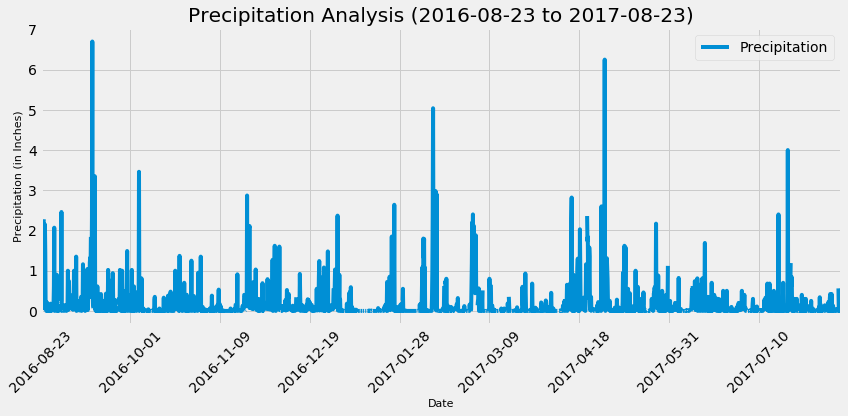

In [142]:
# Plot results from prcp_df, x=date, y=prcp
prcp_df.plot('date','prcp', legend="", figsize=(12,6))
plt.xlabel("Date", size=11)
plt.ylabel("Precipitation (in Inches)", size=11)
plt.legend(["Precipitation"])
plt.title(f"Precipitation Analysis ({last_twelve_months} to {last_row[0]})")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Resources/precipitation_analysis.png")
plt.show()

In [101]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [102]:
# Design a query to show how many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print(f"The dataset has {locations} stations.")

The dataset has 9 stations.


In [118]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
                    .order_by(func.count(Measurement.tobs).desc()).all()
print(f'''                                          TOP 3 STATIONS
**********************************************************************************************************
The most active station was {station_activity[0][0]} with total observations of {station_activity[0][1]}.  
Following a close second with {station_activity[1][1]} total observations was {station_activity[1][0]}.
Finishing our top 3 list was {station_activity[2][0]} with {station_activity[2][1]} total observations.
**********************************************************************************************************
''')    

station_activity

                                          TOP 3 STATIONS
**********************************************************************************************************
The most active station was USC00519281 with total observations of 2772.  
Following a close second with 2724 total observations was USC00519397.
Finishing our top 3 list was USC00513117 with 2709 total observations.
**********************************************************************************************************



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [105]:
station_activity[0][0]

'USC00519281'

In [122]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_pop_station = station_activity[0][0]
results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station == most_pop_station).all()
print(f"""Most active station was {station_activity[0][0]}
**********************************************************
Lowest temperature: {results[0][0]}
Highest temperature: {results[0][1]}
Average temperature: {results[0][2]}
""")

Most active station was USC00519281
**********************************************************
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66378066378067



In [123]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.station, Measurement.tobs)\
        .filter(Measurement.station == most_pop_station)\
        .filter(Measurement.date >= last_twelve_months).all()
tobs_df = pd.DataFrame(tobs)
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


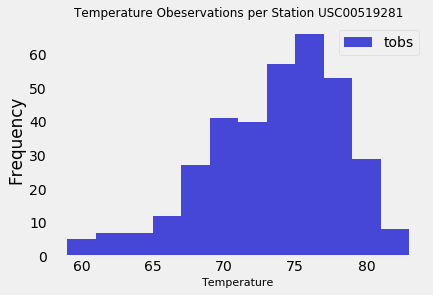

In [141]:
tobs_df.plot.hist(by='station', bins=12, color="mediumblue", alpha=0.7)
plt.title("Temperature Obeservations per Station " + most_pop_station, fontsize=12)
plt.xlabel("Temperature", fontsize=11)
plt.grid()
plt.savefig("Resources/tobs_per_station.png")
plt.show()

In [46]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [51]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = dt.date(2018, 7, 4)
trip_end = dt.date(2018, 7, 15)
py = dt.timedelta(days=365)
results = (calc_temps((trip_start-py), (trip_end-py)))
print(f'''
Trip min temperature: {results[0][0]}
Trip avg temperature: {results[0][1]}
Trip max temperature: {results[0][2]}
''')


Trip min temperature: 69.0
Trip avg temperature: 78.11842105263158
Trip max temperature: 82.0



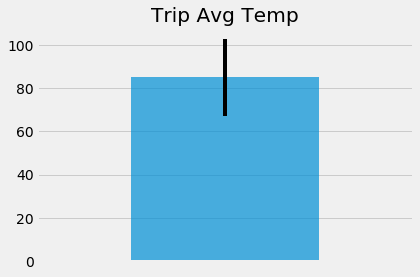

In [140]:
temp_df = pd.DataFrame(results, columns=['min', 'avg', 'max'])
temp_df['avg'].plot(kind='bar', yerr= temp_df['max'] - temp_df['min'], alpha= 0.7)
plt.title("Trip Avg Temp")
plt.savefig("Resources/trip_avg_temp.png")
plt.xticks([])
plt.show()

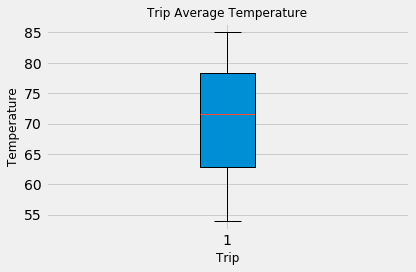

In [143]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
x = range(len(results))
ax.boxplot(results, patch_artist=True)
ax.set_title('Trip Average Temperature', fontsize=12)
ax.set_ylabel("Temperature", fontsize=12)
ax.set_xlabel("Trip", fontsize=12)
fig.tight_layout()
plt.savefig("Resources/trip_avg_temp_boxplot.png")
plt.show()

In [49]:
sel =[Station.station, Station.name, Station.longitude, 
      Station.latitude, Station.elevation, func.sum(Measurement.prcp)]

In [77]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= last_twelve_months).\
    group_by(Station.name).\
    order_by(func.sum(Measurement.prcp).desc()).all()
print(rain)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', -157.8025, 21.3331, 152.4, 147.81000000000006), ('USC00519281', 'WAIHEE 837.5, HI US', -157.84888999999998, 21.45167, 32.9, 70.03000000000003), ('USC00513117', 'KANEOHE 838.1, HI US', -157.8015, 21.4234, 14.6, 48.510000000000026), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', -157.71139, 21.33556, 19.5, 38.01), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', -157.8374, 21.5213, 7.0, 33.239999999999995), ('USC00519397', 'WAIKIKI 717.2, HI US', -157.8168, 21.2716, 3.0, 16.089999999999986), ('USC00517948', 'PEARL CITY, HI US', -157.9751, 21.3934, 11.9, 4.59)]


## Optional Challenge Assignment

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

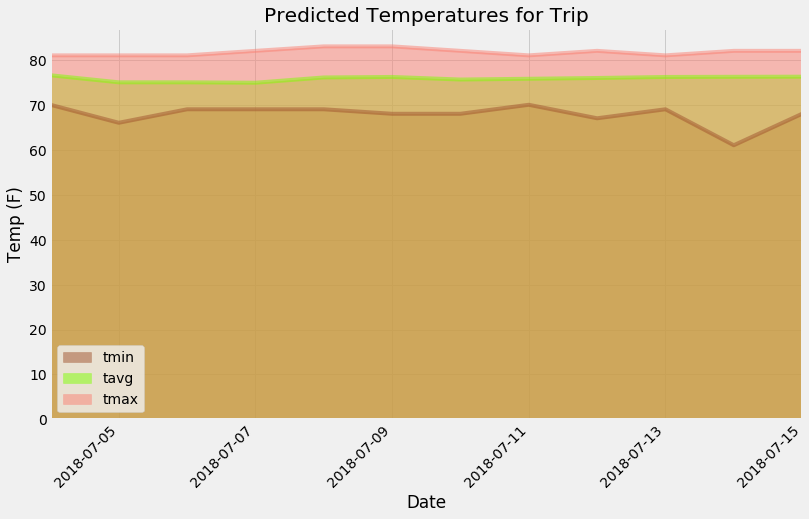

In [145]:
#list of dates for your trip 
dates = pd.date_range(trip_start, trip_end)

#use %m-%d format
trip_mmdd = dates.strftime('%m-%d')

#calculate the normals for each date string and append the results to a list
normals_list = []
for date in trip_mmdd:
    #unpack daily_normals
    normals_list.append(*daily_normals(date))

#make a df
normals_df = pd.DataFrame(normals_list, columns = ['tmin', 'tavg', 'tmax'])

#make the trip dates the index
normals_df['Date'] = dates
normals_df = normals_df.set_index('Date')

#set colors list
colors = ['sienna', 'chartreuse', 'salmon']

#area plot for the predicted temps
normals_df.plot(kind='area', figsize=(12, 8), stacked=False, 
                x_compat=True, color=colors, title='Predicted Temperatures for Trip', rot=45)

#plot labels
plt.xlabel('Date')
plt.ylabel('Temp (F)')

plt.show()